# import libraries

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
from scipy import signal
from scipy import stats
from scipy.signal import butter,filtfilt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA 
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import pywt

from catboost import CatBoostClassifier

# Helper functions

In [3]:
from scipy.signal import welch
def compute_psd(signal, fs):
    freqs, psd = welch(signal, fs=fs,nperseg=12)
    return psd.tolist()




In [24]:
def pre_processing_Of_data(data, colss):
  # data=pd.read_csv(EOG_dataframe)
  #vertical_data=data.drop(data[(data['polarity']=='h')].index, inplace=False)
  data_framee = pd.DataFrame(columns = colss)
  for lenn in range(len(data)):
    n_row = data.iloc[[lenn]]
    label_ = str(data.iloc[lenn]['label'])
    #vertical_horizontal = str(data.iloc[lenn]['polarity'])
    n_row=n_row.drop(columns=['id','label'])
    n_row = n_row.values.tolist()
    n_row = [item for sublist in n_row for item in sublist]
    filterd_sig=butter_bandpass_filter(n_row,low_cutoff=0.5,high_cutoff=20.0,sampling_rate=176,order=2)
    #Down sampling
    resampled__sig=signal.resample(filterd_sig,50)
    flatten_array=resampled__sig.flatten()
    new_row = pd.DataFrame([[label_]  + list(flatten_array)], columns=colss)

    # concatenate the dataframes
    data_framee = pd.concat([data_framee, new_row], ignore_index=True)
  return data_framee

In [25]:
def get_featuers(data, level,col):
  #all_coeffs = [] # each element in this list contains 4 lists for the 4 levels
  #data = pre_processed_data.drop(pre_processed_data[(pre_processed_data['polarity'] == polarity)].index, inplace=False)
  features_dataframe = pd.DataFrame(columns = col)
  for i in range(len(data)):
    row = data.iloc[[i]]
    label_ = str(data.iloc[i]['label'])
    #vertical_horizontal = str(data.iloc[i]['polarity'])
    row = row.drop(columns=['label'])
    row = row.values.tolist()
    row = [item for sublist in row for item in sublist]
    wavelet = 'db4' # Daubechies 4
    coeffs = pywt.wavedec(row, wavelet, level = level)

    frow=create_statistical_features(coeffs,level)
    #psd
    new_row = pd.DataFrame([[label_] + list(frow)], columns=col)
    features_dataframe = pd.concat([features_dataframe, new_row], ignore_index=True)

  return features_dataframe

In [26]:
def get_featuers_psd(data, level,col):
  #all_coeffs = [] # each element in this list contains 4 lists for the 4 levels
  #data = pre_processed_data.drop(pre_processed_data[(pre_processed_data['polarity'] == polarity)].index, inplace=False)
  features_dataframe = pd.DataFrame(columns = col)
  for i in range(len(data)):
    row = data.iloc[[i]]
    label_ = str(data.iloc[i]['label'])
    #vertical_horizontal = str(data.iloc[i]['polarity'])
    row = row.drop(columns=['label'])
    row = row.values.tolist()
    row = [item for sublist in row for item in sublist]
    #wavelet = 'db4' # Daubechies 4
    
    #coeffs = pywt.wavedec(row, wavelet, level = level)

    #frow=create_statistical_features(coeffs,level)
    #psd
    fs = 50  # Specify your sampling frequency
    psd = compute_psd(row, fs)

    new_row = pd.DataFrame([[label_] + list(psd)], columns=col)
    features_dataframe = pd.concat([features_dataframe, new_row], ignore_index=True)

  return features_dataframe

In [27]:
def create_statistical_features(coeffs, level):  

  feature_row = []
  for i in range(level + 1):
    feature_row = feature_row + concatenate_features(coeffs[i])

  return feature_row



In [28]:
def mean(data):
    return np.mean(data,axis=-1)    

def var(data):
        return np.var(data,axis=-1)

def skewness(data):
    return stats.skew(data,axis=-1)

def kurtosis(data):
    return stats.kurtosis(data,axis=-1)

def concatenate_features(data):
    return [mean(data), var(data), skewness(data), kurtosis(data)]
    


In [29]:
def butter_bandpass_filter(input,low_cutoff,high_cutoff,sampling_rate,order):
  nyq=0.5*sampling_rate
  low=low_cutoff/nyq
  high=high_cutoff/nyq
  numerator,denominator=butter(order,[low,high],btype='band',output='ba',analog=False,fs=None)
  filterd=filtfilt(numerator,denominator,input)
  return filterd

In [30]:
def ploting_signal(dataframe, nrow, data_or_pre):
  n_row = dataframe.iloc[[nrow]]
  condition = lambda x: n_row.drop(columns=['id','label']) if x == 1 else n_row.drop(columns=['label'])
  n_row=condition(data_or_pre)
  n_row = n_row.values.tolist()
  n_row = [item for sublist in n_row for item in sublist]
  plt.figure(figsize=(12,6))
  plt.plot(np.arange(0,len(n_row)),n_row)
  plt.xlabel("t")
  plt.ylabel("a")
  plt.show()
  

In [31]:
def FeatureScalling(X):
  for column in X.columns:
    X[column] = (X[column] - X[column].min()) /(X[column].max() - X[column].min())
  return X

In [32]:
def LogisticRegressionModel(X_train,y_train,X_test,y_test,iter=10000):
    model =LogisticRegression(max_iter=iter)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    print('Mean Square Error:', metrics.mean_squared_error(y_test, prediction))
    print('Accuracy :', metrics.accuracy_score(y_test, prediction)) 
    return model,prediction

In [33]:
def cat_boost(X_train,y_train,X_test,y_test):
  cat_clf = CatBoostClassifier()
  cat_clf.fit(X_train,y_train)
  preds = cat_clf.predict(X_test)
  print('Accuracy :', metrics.accuracy_score(y_test, preds)) 
  return cat_clf,preds

In [34]:
def random_forest(X_train,y_train,X_test,y_test):
  rf = RandomForestClassifier()
  rf.fit(X_train,y_train)
  preds = rf.predict(X_test)
  print('Accuracy :', metrics.accuracy_score(y_test, preds)) 
  return rf,preds

# Load Data

In [35]:
url = 'https://drive.google.com/file/d/1LwxEtspllLBV6w2IA_NmBxicQdWRday4/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data = pd.read_csv(path)

In [36]:
data.head(5)

,id,label,polarity,0,1,2,3,4,5,6,...,241,242,243,244,245,246,247,248,249,250
0,10,Down,h,123.0,126.0,134.0,131.0,125.0,131.0,130.0,...,149.0,143.0,139.0,143.0,141.0,139.0,138.0,142.0,136.0,137.0
1,10,Down,v,123.0,122.0,127.0,130.0,123.0,123.0,127.0,...,137.0,134.0,133.0,130.0,136.0,135.0,130.0,139.0,136.0,129.0
2,11,Down,h,127.0,135.0,130.0,135.0,129.0,127.0,133.0,...,135.0,143.0,140.0,139.0,144.0,142.0,139.0,139.0,143.0,134.0
3,11,Down,v,120.0,132.0,120.0,127.0,126.0,125.0,120.0,...,121.0,128.0,137.0,131.0,124.0,133.0,129.0,124.0,131.0,130.0
4,12,Down,h,133.0,137.0,134.0,132.0,137.0,136.0,135.0,...,152.0,143.0,141.0,148.0,148.0,144.0,149.0,147.0,150.0,150.0


In [37]:
import pandas as pd
axis_h = data[data['polarity'] == 'h']
axis_v = data[data['polarity'] == 'v']

In [38]:
data = pd.merge(axis_v, axis_h, on=['id','label'])

In [39]:
data.head()

,id,label,polarity_x,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,241_y,242_y,243_y,244_y,245_y,246_y,247_y,248_y,249_y,250_y
0,10,Down,v,123.0,122.0,127.0,130.0,123.0,123.0,127.0,...,149.0,143.0,139.0,143.0,141.0,139.0,138.0,142.0,136.0,137.0
1,11,Down,v,120.0,132.0,120.0,127.0,126.0,125.0,120.0,...,135.0,143.0,140.0,139.0,144.0,142.0,139.0,139.0,143.0,134.0
2,12,Down,v,136.0,130.0,141.0,136.0,137.0,135.0,144.0,...,152.0,143.0,141.0,148.0,148.0,144.0,149.0,147.0,150.0,150.0
3,13,Down,v,148.0,150.0,139.0,144.0,144.0,144.0,139.0,...,135.0,135.0,128.0,131.0,132.0,132.0,131.0,133.0,135.0,136.0
4,14,Down,v,118.0,112.0,121.0,120.0,116.0,115.0,119.0,...,136.0,143.0,138.0,135.0,144.0,133.0,133.0,137.0,140.0,95.0


In [40]:
data=data.drop(['polarity_x','polarity_y'],axis=1)

# Pre Processing

**Create an Empty Data Frame**

In [41]:
cols = ["label"] + [f"sample{i}" for i in range(50)]

**pre processed data**

In [42]:
pre_processed_data=pre_processing_Of_data(data, cols)

In [43]:
pre_processed_data.head()

,label,sample0,sample1,sample2,sample3,sample4,sample5,sample6,sample7,sample8,...,sample40,sample41,sample42,sample43,sample44,sample45,sample46,sample47,sample48,sample49
0,Down,3.050791,-0.865759,0.805123,0.527432,2.054454,2.776745,3.587159,0.869774,2.245053,...,2.612917,4.993582,3.251023,4.525844,3.281095,4.386487,2.260357,12.235310,15.817698,8.044334
1,Down,5.617055,2.413506,3.113708,0.924285,2.154764,0.555799,0.216272,2.031482,0.064744,...,-0.650675,4.667686,3.893687,6.392529,6.242369,7.411270,7.341407,8.060672,7.406513,9.803809
2,Down,-0.627148,3.821619,2.828753,2.050964,2.363588,4.731671,1.978488,1.581987,1.327882,...,-28.694104,10.204375,5.275527,10.424270,6.921940,6.909993,4.245074,1.245922,-0.970576,-3.228186
3,Down,-1.289157,1.248479,-0.445307,0.897010,-0.834174,-1.204685,-1.840080,-2.359819,-2.090484,...,0.808549,4.784649,4.093561,3.995711,1.341646,3.607457,4.849563,6.023194,5.276624,0.292850
4,Down,19.354578,-6.371295,2.912530,-2.330419,1.352826,-0.710954,-0.663344,-3.390855,-0.411237,...,-8.299883,0.610050,1.185967,7.101273,8.074020,16.870992,20.432883,33.553062,35.357563,52.647064


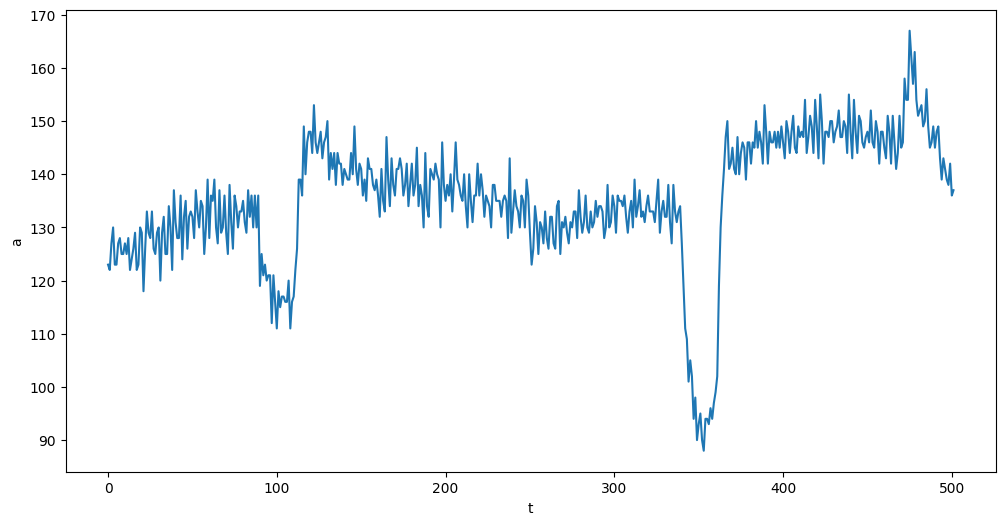

In [44]:
ploting_signal(data,0,1)

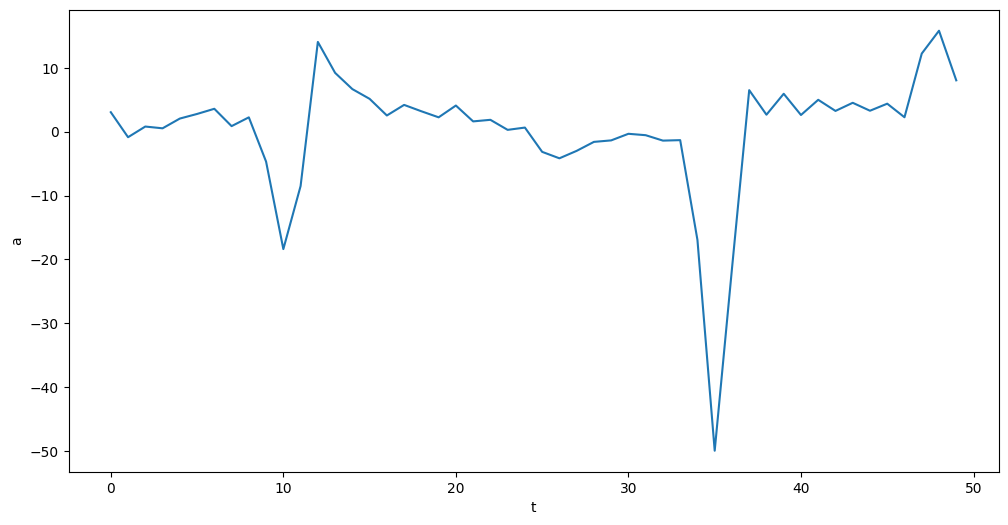

In [45]:
ploting_signal(pre_processed_data,0,0)

# Feature Extraction

In [46]:
cols_featuers = ["label"] + [f"col{i}" for i in range(20)]

In [ ]:
featuered_data=get_featuers(pre_processed_data,4,cols_featuers)

/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients w

In [ ]:
featuered_data.head()

,label,col0,col1,col2,col3,col4,col5,col6,col7,col8,...,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19
0,Down,6.633673,192.103477,1.762140,2.434505,1.589210,152.047401,0.141055,-1.047610,-1.670412,...,0.479188,1.372085,-1.196092,91.870084,-2.421134,6.128305,0.350846,24.406013,0.608581,3.330199
1,Down,11.229954,292.145136,1.312019,1.890946,1.307973,141.939691,-0.408488,0.738060,-0.590381,...,-0.149222,1.035381,2.139668,67.452225,1.068896,1.617153,0.274017,17.860334,0.406338,3.627529
2,Down,6.209481,35.545323,-1.440833,1.177865,-0.534691,132.078045,0.547415,0.503275,1.618606,...,-0.768929,-0.151544,-2.150706,95.367397,-2.850154,8.193885,-0.097014,13.788663,-0.848552,3.042637
3,Down,1.082113,140.958899,0.857261,0.511722,0.366814,126.410138,-0.248883,-0.274343,1.120601,...,-0.527782,0.690396,1.596859,76.158543,1.179279,0.984252,-0.454921,12.180019,0.604458,2.222909
4,Down,24.180724,3805.602356,2.241061,3.538858,2.748229,1118.719131,0.010677,0.162561,-2.318443,...,-0.480510,0.504451,2.284776,71.972190,0.647335,0.764419,1.034427,24.005866,0.788747,2.470155


# Label encoding

In [ ]:
df=featuered_data
encoded_Data=df

In [ ]:
#Binary represntation for label
df = pd.get_dummies(featuered_data, columns=["label"])
df["encoded_label"] = df["label_Blink"].astype(str) + df["label_Down"].astype(str) + df["label_Left"].astype(str) + df["label_Right"].astype(str) + df["label_Up"].astype(str)
df = df.drop(["label_Blink", "label_Down", "label_Left","label_Right","label_Up"], axis=1)
encoded_Data=df

In [ ]:
#label enconding for y
import pandas as pd
from sklearn.preprocessing import LabelEncoder
df = featuered_data

le = LabelEncoder()

df['encoded_label'] = le.fit_transform(df['label'])
df = df.drop(["label"], axis=1)
encoded_Data=df

In [ ]:
df.head(5)

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,...,col11,col12,col13,col14,col15,col16,col17,col18,col19,encoded_label
0,6.633673,192.103477,1.762140,2.434505,1.589210,152.047401,0.141055,-1.047610,-1.670412,205.536663,...,1.372085,-1.196092,91.870084,-2.421134,6.128305,0.350846,24.406013,0.608581,3.330199,1
1,11.229954,292.145136,1.312019,1.890946,1.307973,141.939691,-0.408488,0.738060,-0.590381,146.216355,...,1.035381,2.139668,67.452225,1.068896,1.617153,0.274017,17.860334,0.406338,3.627529,1
2,6.209481,35.545323,-1.440833,1.177865,-0.534691,132.078045,0.547415,0.503275,1.618606,130.055662,...,-0.151544,-2.150706,95.367397,-2.850154,8.193885,-0.097014,13.788663,-0.848552,3.042637,1
3,1.082113,140.958899,0.857261,0.511722,0.366814,126.410138,-0.248883,-0.274343,1.120601,196.073967,...,0.690396,1.596859,76.158543,1.179279,0.984252,-0.454921,12.180019,0.604458,2.222909,1
4,24.180724,3805.602356,2.241061,3.538858,2.748229,1118.719131,0.010677,0.162561,-2.318443,225.276652,...,0.504451,2.284776,71.972190,0.647335,0.764419,1.034427,24.005866,0.788747,2.470155,1


In [ ]:
encoded_Data.head()

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,...,col11,col12,col13,col14,col15,col16,col17,col18,col19,encoded_label
0,6.633673,192.103477,1.762140,2.434505,1.589210,152.047401,0.141055,-1.047610,-1.670412,205.536663,...,1.372085,-1.196092,91.870084,-2.421134,6.128305,0.350846,24.406013,0.608581,3.330199,1
1,11.229954,292.145136,1.312019,1.890946,1.307973,141.939691,-0.408488,0.738060,-0.590381,146.216355,...,1.035381,2.139668,67.452225,1.068896,1.617153,0.274017,17.860334,0.406338,3.627529,1
2,6.209481,35.545323,-1.440833,1.177865,-0.534691,132.078045,0.547415,0.503275,1.618606,130.055662,...,-0.151544,-2.150706,95.367397,-2.850154,8.193885,-0.097014,13.788663,-0.848552,3.042637,1
3,1.082113,140.958899,0.857261,0.511722,0.366814,126.410138,-0.248883,-0.274343,1.120601,196.073967,...,0.690396,1.596859,76.158543,1.179279,0.984252,-0.454921,12.180019,0.604458,2.222909,1
4,24.180724,3805.602356,2.241061,3.538858,2.748229,1118.719131,0.010677,0.162561,-2.318443,225.276652,...,0.504451,2.284776,71.972190,0.647335,0.764419,1.034427,24.005866,0.788747,2.470155,1


# Models

 ## data prepration for models

In [ ]:
X=encoded_Data.drop(["encoded_label"],axis=1)
X=FeatureScalling(X)
y=encoded_Data[["encoded_label"]]
# convert data to numpy array
#X_np=X.values
#y_np=y.values
#y_np=encoded_labels

In [ ]:
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [ ]:
print("size of trining examples:  "+str(len(y_train)))
print("size of dev examples:  "+str(len(y_dev)))

size of trining examples:  80
size of dev examples:  20


In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_dev, y_dev, test_size=0.5, random_state=42,stratify=y_dev)

In [ ]:
print("size of validation  examples:  "+str(len(y_val)))
print("size of test examples:  "+str(len(y_test)))

size of validation  examples:  10
size of test examples:  10


##download data for game 

In [ ]:
horizontal_idx=np.logical_or(y_test['label']=='Left',y_test['label']=='Right')

In [ ]:
horizontal_label=y_test[horizontal_idx]
horizontal_data=X_test[horizontal_idx]
horizontal_data

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19
63,0.251762,0.000476,0.685204,0.471249,0.737629,0.014991,0.532166,0.504828,0.193563,0.071424,0.171745,0.586506,0.374367,0.055774,0.672920,0.349891,0.301968,0.500697,0.623078,0.430293
54,0.853353,0.964459,0.991847,0.942764,0.826281,0.876765,0.290964,0.579584,0.000000,0.900839,0.424773,0.394399,0.676668,0.718344,0.823756,0.536778,0.759090,0.634561,0.591763,0.047995
53,0.205204,0.007841,0.754060,0.385912,0.335026,0.004436,0.496145,0.147047,0.746659,0.021887,0.909427,0.715784,0.446904,0.010493,0.668387,0.348461,0.312282,0.402445,0.382874,0.452914
77,0.288738,0.000740,0.292786,0.307912,1.000000,0.043333,0.914606,0.746368,0.444519,0.011582,0.489788,0.094366,0.285921,0.434385,0.664319,0.472266,0.516947,0.495996,0.623133,0.254485


In [ ]:
verticle_idx=np.logical_or(y_test['label']=='Up',y_test['label']=='Down')


In [ ]:
verticle_label=y_test[verticle_idx]
verticle_data=X_test[verticle_idx]
verticle_data

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19
1,0.383294,0.008229,0.785165,0.630863,0.559277,0.016038,0.231166,0.578897,0.492810,0.029470,0.492085,0.326179,0.598124,0.111782,0.670187,0.197534,0.381975,0.135606,0.537076,0.152045
94,0.218021,0.046890,0.070701,0.865390,0.419837,0.076179,0.522551,0.552201,0.643167,0.017697,0.408103,0.182182,0.420805,0.216746,0.476752,0.211192,0.068068,0.144143,0.171940,0.547383
95,0.534885,0.038627,0.799892,0.603604,0.455571,0.069935,0.330825,0.332725,0.568717,0.040828,0.370163,0.214361,0.530807,0.108767,0.744332,0.432478,0.346117,0.095338,0.630813,0.292817
11,0.327272,0.000314,0.366510,0.080198,0.526461,0.000126,0.705724,0.355601,0.508938,0.014574,0.485847,0.092826,0.225713,0.032639,0.434131,0.237284,0.167267,0.171259,0.414504,0.397480


In [ ]:
verticle_label.to_csv('verticle_label.csv',index=False)

##catboost Model

In [ ]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import GridSearchCV

# Prepare the data as a CatBoost Pool object
train_pool = Pool(X_train, y_train)

# Define the parameter grid for grid search
param_grid = {
    'iterations': [1000],  # Number of boosting iterations
    'learning_rate': [0.1, 0.01, 0.001],  # Learning rate
    'depth': [4,5,6],  # Maximum depth of the trees
    'l2_leaf_reg': [5, 10, 15 , 20 , 25 ,30]  # L2 regularization strength
}

# Create an instance of CatBoostClassifier
model = CatBoostClassifier()

# Perform grid search using cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameter combination and its corresponding performance
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Train the final model with the best parametersc
final_model = CatBoostClassifier(**best_params)
final_model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = final_model.predict(X_test)


In [ ]:
from catboost import CatBoostClassifier

# Create an instance of CatBoostClassifier with regularization parameters
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    l2_leaf_reg=10,  # Set the L2 regularization strength
    depth=6
)

# Train the model
model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=False)

# Make predictions
train_preds=model.predict(X_train)
print('train Accuracy :', metrics.accuracy_score(y_train, train_preds)) 

test_preds=model.predict(X_val)
print('val Accuracy :', metrics.accuracy_score(y_val, test_preds)) 

test_preds=model.predict(X_test)
print('test Accuracy :', metrics.accuracy_score(y_test, test_preds)) 


train Accuracy : 1.0
val Accuracy : 0.8
test Accuracy : 0.9


In [ ]:
model,preds=cat_boost(X_train,y_train,X_val,y_val)

Learning rate set to 0.069563
0:	learn: 1.5710615	total: 10ms	remaining: 10s
1:	learn: 1.5465936	total: 16.6ms	remaining: 8.27s
2:	learn: 1.5244937	total: 23.3ms	remaining: 7.73s
3:	learn: 1.4989281	total: 30ms	remaining: 7.46s
4:	learn: 1.4701359	total: 36ms	remaining: 7.16s
5:	learn: 1.4459187	total: 42ms	remaining: 6.96s
6:	learn: 1.4209678	total: 47.6ms	remaining: 6.75s
7:	learn: 1.3909344	total: 53.3ms	remaining: 6.61s
8:	learn: 1.3622237	total: 59.2ms	remaining: 6.52s
9:	learn: 1.3446265	total: 65ms	remaining: 6.43s
10:	learn: 1.3160988	total: 70.7ms	remaining: 6.35s
11:	learn: 1.3015780	total: 76.5ms	remaining: 6.3s
12:	learn: 1.2844337	total: 82ms	remaining: 6.23s
13:	learn: 1.2675572	total: 87.5ms	remaining: 6.16s
14:	learn: 1.2530463	total: 93.5ms	remaining: 6.14s
15:	learn: 1.2354330	total: 99.4ms	remaining: 6.12s
16:	learn: 1.2131314	total: 105ms	remaining: 6.1s
17:	learn: 1.1938784	total: 111ms	remaining: 6.07s
18:	learn: 1.1701493	total: 117ms	remaining: 6.05s
19:	learn: 

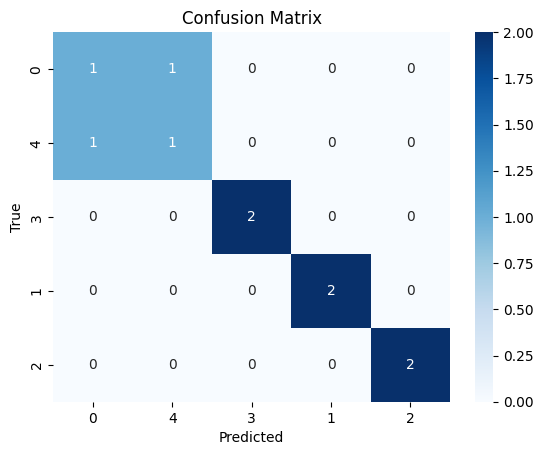

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Define the labels for the confusion matrix
labels = y_val['encoded_label'].unique()

true_label=y_val

prediction=preds
# Create confusion matrix
cm = confusion_matrix(true_label,prediction, labels=labels)

# Create a dataframe from the confusion matrix
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Create heatmap using Seaborn
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


In [ ]:
model,preds=cat_boost(X_train,y_train,X_test,y_test)

Learning rate set to 0.069563
0:	learn: 1.5710615	total: 5.92ms	remaining: 5.92s
1:	learn: 1.5465936	total: 23ms	remaining: 11.5s
2:	learn: 1.5244937	total: 32ms	remaining: 10.6s
3:	learn: 1.4989281	total: 38.6ms	remaining: 9.62s
4:	learn: 1.4701359	total: 45.4ms	remaining: 9.04s
5:	learn: 1.4459187	total: 52.9ms	remaining: 8.76s
6:	learn: 1.4209678	total: 59.8ms	remaining: 8.49s
7:	learn: 1.3909344	total: 67.7ms	remaining: 8.4s
8:	learn: 1.3622237	total: 75.1ms	remaining: 8.26s
9:	learn: 1.3446265	total: 83ms	remaining: 8.22s
10:	learn: 1.3160988	total: 90.8ms	remaining: 8.16s
11:	learn: 1.3015780	total: 99.3ms	remaining: 8.18s
12:	learn: 1.2844337	total: 107ms	remaining: 8.12s
13:	learn: 1.2675572	total: 115ms	remaining: 8.11s
14:	learn: 1.2530463	total: 122ms	remaining: 8.04s
15:	learn: 1.2354330	total: 131ms	remaining: 8.06s
16:	learn: 1.2131314	total: 143ms	remaining: 8.27s
17:	learn: 1.1938784	total: 157ms	remaining: 8.55s
18:	learn: 1.1701493	total: 171ms	remaining: 8.85s
19:	le

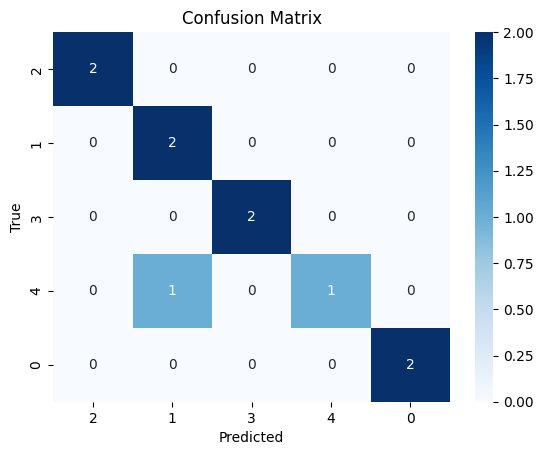

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Define the labels for the confusion matrix
labels = y_test['encoded_label'].unique()

true_label=y_test

prediction=preds
# Create confusion matrix
cm = confusion_matrix(true_label,prediction, labels=labels)

# Create a dataframe from the confusion matrix
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Create heatmap using Seaborn
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


In [ ]:
model,preds=random_forest(X_train,y_train,X_val,y_val)

<ipython-input-14-f524caf6175c>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train,y_train)


Accuracy : 0.8


In [ ]:
# Make predictions
train_preds=model.predict(X_train)
print('train Accuracy :', metrics.accuracy_score(y_train, train_preds)) 

test_preds=model.predict(X_val)
print('val Accuracy :', metrics.accuracy_score(y_val, test_preds)) 

test_preds=model.predict(X_test)
print('test Accuracy :', metrics.accuracy_score(y_test, test_preds)) 


train Accuracy : 1.0
val Accuracy : 0.8
test Accuracy : 0.9


##Logistic Regression Model

In [ ]:
model,preds=LogisticRegressionModel(X_train.values,y_train.values,X_val.values,y_val.values)

Mean Square Error: 1.6
Accuracy : 0.5


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Make predictions
train_preds=model.predict(X_train)
print('train Accuracy :', metrics.accuracy_score(y_train, train_preds)) 

test_preds=model.predict(X_val)
print('val Accuracy :', metrics.accuracy_score(y_val, test_preds)) 

test_preds=model.predict(X_test)
print('test Accuracy :', metrics.accuracy_score(y_test, test_preds)) 

train Accuracy : 0.725
val Accuracy : 0.5
test Accuracy : 0.8


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


## KNN classfier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Create a KNN classifier with k=5
knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn.predict(X_val)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.5


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


### PCA

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
# create a PCA object with two components
pca = PCA(n_components=10)

# fit the PCA model to the data and transform the data
Xtrain_pca = pca.fit_transform(X_train)
Xtest_pca=pca.transform(X_test)
# print the explained variance ratio of the two principal components
print(pca.explained_variance_ratio_)

[0.27439311 0.14401749 0.1028039  0.08406213 0.07258379 0.06111596
 0.05423196 0.04647479 0.04409754 0.03343271]


In [ ]:
model,preds=LogisticRegressionModel(Xtrain_pca,y_train,Xtest_pca,y_test)

Mean Square Error: 1.0
Accuracy : 0.8


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#after applaying pca
train_preds=model.predict(Xtrain_pca)
print('train Accuracy :', metrics.accuracy_score(y_train, train_preds)) 
test_preds=model.predict(Xtest_pca)
print('test Accuracy :', metrics.accuracy_score(y_test, test_preds)) 

train Accuracy : 0.6375
test Accuracy : 0.8


#Bouns PSD feature extraction

In [47]:
cols_featuers = ["label"] + [f"col{i}" for i in range(7)]

In [48]:
featuered_data=get_featuers_psd(pre_processed_data,2,cols_featuers)

In [49]:
featuered_data.head()

,label,col0,col1,col2,col3,col4,col5,col6
0,Down,1.397651,7.413691,7.831179,4.219526,1.943930,0.596429,0.073909
1,Down,1.552218,5.401606,5.024887,3.356849,1.629578,0.636457,0.168854
2,Down,0.211908,6.355382,4.502801,2.516918,1.194323,0.688358,0.225616
3,Down,1.633009,6.965851,5.273968,3.019392,1.580407,0.564055,0.148481
4,Down,1.193231,6.112557,4.472801,2.809534,1.400694,0.683420,0.311225


In [50]:
len(featuered_data)

100

# Label encoding

In [51]:
df=featuered_data
encoded_Data=df

In [52]:
df.head(5)

,label,col0,col1,col2,col3,col4,col5,col6
0,Down,1.397651,7.413691,7.831179,4.219526,1.943930,0.596429,0.073909
1,Down,1.552218,5.401606,5.024887,3.356849,1.629578,0.636457,0.168854
2,Down,0.211908,6.355382,4.502801,2.516918,1.194323,0.688358,0.225616
3,Down,1.633009,6.965851,5.273968,3.019392,1.580407,0.564055,0.148481
4,Down,1.193231,6.112557,4.472801,2.809534,1.400694,0.683420,0.311225


# Models

 ## data prepration for models

In [53]:
X=encoded_Data.drop(["label"],axis=1)
X=FeatureScalling(X)
y=encoded_Data[["label"]]
# convert data to numpy array
#X_np=X.values
#y_np=y.values
#y_np=encoded_labels

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42,stratify=y)

In [55]:
print("size of trining examples:  "+str(len(y_train)))
print("size of dev examples:  "+str(len(y_test)))

size of trining examples:  90
size of dev examples:  10


In [ ]:
y_test

,label
0,Down
93,Up
66,Left
26,Blink
42,Right
1,Down
34,Blink
83,Up
68,Left
54,Right


##catboost Model

In [56]:
from catboost import CatBoostClassifier

# Create an instance of CatBoostClassifier with regularization parameters
model = CatBoostClassifier(
    iterations=1000 ,
    learning_rate=0.1,
    l2_leaf_reg=0,  # Set the L2 regularization strength
    depth=6
)

# Train the model
model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=False)

# Make predictions
train_preds=model.predict(X_train)
print('train Accuracy :', metrics.accuracy_score(y_train, train_preds)) 
val_preds=model.predict(X_test)
print('test Accuracy :', metrics.accuracy_score(y_test, val_preds)) 

train Accuracy : 1.0
test Accuracy : 0.8


In [57]:
rf,preds=random_forest(X_train,y_train,X_test,y_test)

Accuracy : 0.8


<ipython-input-34-f524caf6175c>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train,y_train)
